# Batch normalization
Batch normalization means that we normalize each layer's inputs by using the mean and variance of the values in the current batch.

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

In [10]:
# number of subprocesses to use for data loading
num_workers = 0
batch_size = 64

# ToTensor(): FloatTensor
# tensor(): dtype 지정 가능
transform = transforms.ToTensor()

# Data Load

In [11]:
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

# Visualize data


(64, 1, 28, 28)
<class 'numpy.ndarray'>
(28, 28)


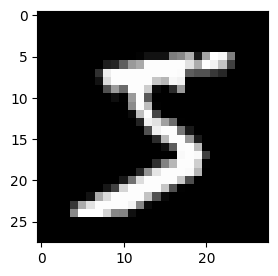

In [14]:
# obtain one batch of training images
# iter(train_loader): train_loader를 iterator로 변환
# next()로 배치 단위로 데이터를 가져옴
# 첫 번째 mini-batch의 데이터를 가져옴
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

print(images.shape)
print(type(images))

# get one image from batch
# squeeze: 배열에서 크기가 1인 차원을 제거함
# images[0].shape: (1, 28, 28)이므로 squeeze를 하면 크기가 1인 차원이 제거됨
img = np.squeeze(images[0])
print(img.shape)

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = 'gray')

# NN classes for testing

1. Layers with batch normalization do **not** include a bias term.
2. We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d) function to handle the math. This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers.
3. We add the batch normalization layer **before** calling the activation function.

In [16]:
class NeuralNet(nn.Module):
    def __init__(self, use_batch_norm, input_size = 784, hidden_dim = 256, output_size = 10):
        '''
        type(use_batch_norm): bool
            pass layer of batch normalization if true otherwise false
        '''
        super(NeuralNet, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm

        if use_batch_norm:
            self.fc1 = nn.Linear(input_size, hidden_dim * 2, bias = False)
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim * 2)

        else:
            self.fc1 = nn.Linear(input_size, hidden_dim * 2)

        if use_batch_norm:
            self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim, bias = False)
            self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        else:
            self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # flatten image
        x = x.view(-1, 28 * 28)

        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = F.relu(x)

        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x

# create model for testing

In [17]:
net_batchnorm = NeuralNet(use_batch_norm = True)
net_no_norm = NeuralNet(use_batch_norm = False)

print(net_batchnorm)
print()
print(net_no_norm)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


# Training


>mode: .train() / .eval()

In [18]:
def train(model, n_epochs = 10):
    n_epochs = n_epochs
    losses = []

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
    # set model to training mode
    model.train()

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0

        batch_count = 0
        for batch_idx, (data, label) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            batch_count += 1

        losses.append(train_loss / batch_count)
        print(f"Epoch: {epoch} \t Training Loss:{train_loss / batch_count:.6f}")

    return losses


# comparing models

In [19]:
losses_batchnorm = train(net_batchnorm)

Epoch: 1 	 Training Loss:0.390524
Epoch: 2 	 Training Loss:0.162971
Epoch: 3 	 Training Loss:0.113222
Epoch: 4 	 Training Loss:0.084274
Epoch: 5 	 Training Loss:0.064450
Epoch: 6 	 Training Loss:0.049933
Epoch: 7 	 Training Loss:0.038985
Epoch: 8 	 Training Loss:0.030646
Epoch: 9 	 Training Loss:0.024241
Epoch: 10 	 Training Loss:0.019410


In [20]:
losses_no_norm = train(net_no_norm)

Epoch: 1 	 Training Loss:1.613615
Epoch: 2 	 Training Loss:0.514734
Epoch: 3 	 Training Loss:0.377691
Epoch: 4 	 Training Loss:0.331075
Epoch: 5 	 Training Loss:0.302399
Epoch: 6 	 Training Loss:0.280404
Epoch: 7 	 Training Loss:0.261699
Epoch: 8 	 Training Loss:0.244890
Epoch: 9 	 Training Loss:0.229481
Epoch: 10 	 Training Loss:0.215327


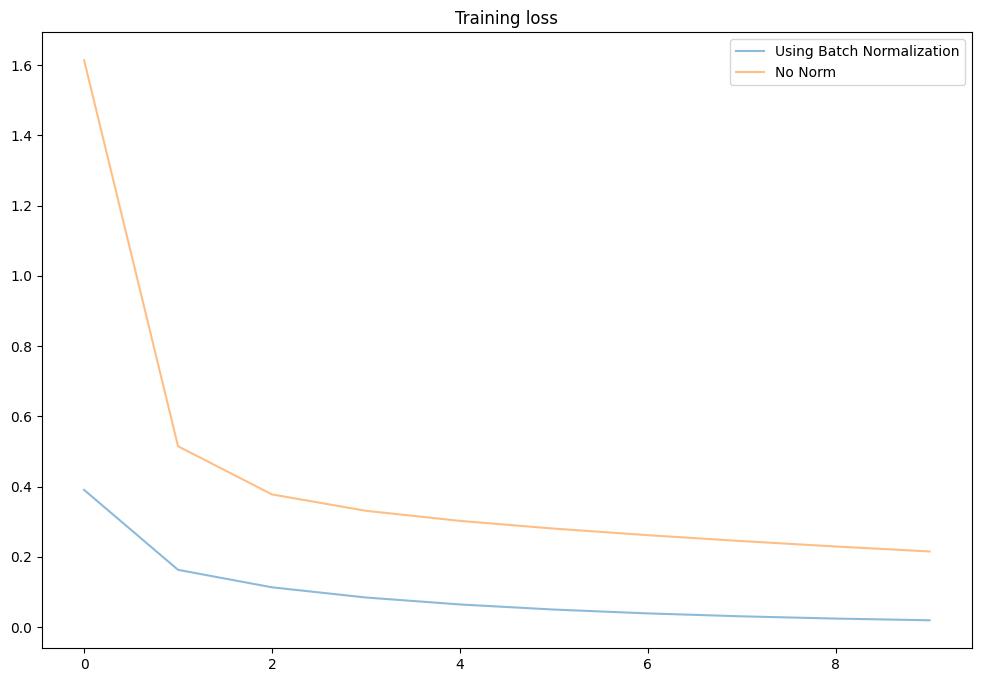

In [21]:
fig, ax = plt.subplots(figsize = (12, 8))

plt.plot(losses_batchnorm, label = 'Using Batch Normalization', alpha = 0.5)
plt.plot(losses_no_norm, label = 'No Norm', alpha = 0.5)
plt.title('Training loss')
plt.legend()
plt.show()

# Testing

In [30]:
def test(model, train):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0

    if (train == True):
        model.train()
    else:
        model.eval()

    criterion = nn.CrossEntropyLoss()
    # 1번의 epoch
    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # test에는 optimizer이 없음(파라미터를 업데이트하지 않으므로)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * batch_size
        _, pred = torch.max(output, 1) # return (prob., predicted class)
        # label.data: label 텐서의 데이터
        # view_as(pred): pred와 같은 shape을 가지도록 텐서의 모양 변형
        # eq: pred와 label.data가 같은지 확인
        # 같으면 True, 다르면 False 반환
        # squeeze: 크기가 1인 차원을 제거
        # 최종적으로 correct는 (64,)의 shape을 가짐
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        for i in range(batch_size):
            label = target.data[i]
            # label이 class_correct의 idx가 됨
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print(f'Test Loss: {test_loss / len(test_loader.dataset):.6f}')

    for i in range(10):
        if class_total[i] > 0:
            print(f'Test Accuracy of {str(i)}: {100 * class_correct[i] / class_total[i]}% ({np.sum(class_correct[i]) / np.sum(class_total[i])})')
        else:
            print(f"Test Accuracy of {str[i]}: N/A (no training example)")

    print(f'\nTest Accuracy (Overall): {100 * np.sum(class_correct) / np.sum(class_total)}% ({np.sum(class_correct)} / {np.sum(class_total)})')


>Train mode
batch normalization will use batch statistics to calculate the batch norm
>Test mode
batch normalization will use population mean and varaince from the entire training set

In [31]:
# train mode
test(net_batchnorm, train = True)

Test Loss: 0.079948
Test Accuracy of 0: 99.08163265306122% (0.9908163265306122)
Test Accuracy of 1: 99.20704845814979% (0.9920704845814978)
Test Accuracy of 2: 96.80232558139535% (0.9680232558139535)
Test Accuracy of 3: 97.82178217821782% (0.9782178217821782)
Test Accuracy of 4: 97.35234215885947% (0.9735234215885947)
Test Accuracy of 5: 97.42152466367713% (0.9742152466367713)
Test Accuracy of 6: 97.39039665970772% (0.9739039665970772)
Test Accuracy of 7: 97.17898832684826% (0.9717898832684825)
Test Accuracy of 8: 96.91991786447639% (0.9691991786447639)
Test Accuracy of 9: 96.72943508424183% (0.9672943508424182)

Test Accuracy (Overall): 97.61% (9761.0 / 10000.0)


In [32]:
# test mode
test(net_batchnorm, train = False)

Test Loss: 0.067277
Test Accuracy of 0: 99.08163265306122% (0.9908163265306122)
Test Accuracy of 1: 99.11894273127753% (0.9911894273127754)
Test Accuracy of 2: 97.67441860465117% (0.9767441860465116)
Test Accuracy of 3: 98.31683168316832% (0.9831683168316832)
Test Accuracy of 4: 97.55600814663951% (0.9755600814663951)
Test Accuracy of 5: 97.86995515695067% (0.9786995515695067)
Test Accuracy of 6: 98.43423799582463% (0.9843423799582464)
Test Accuracy of 7: 96.49805447470817% (0.9649805447470817)
Test Accuracy of 8: 97.53593429158111% (0.9753593429158111)
Test Accuracy of 9: 97.52229930624381% (0.9752229930624381)

Test Accuracy (Overall): 97.97% (9797.0 / 10000.0)


In [33]:
test(net_no_norm, train = False)

Test Loss: 0.207151
Test Accuracy of 0: 98.36734693877551% (0.9836734693877551)
Test Accuracy of 1: 98.14977973568281% (0.9814977973568282)
Test Accuracy of 2: 90.98837209302326% (0.9098837209302325)
Test Accuracy of 3: 93.06930693069307% (0.9306930693069307)
Test Accuracy of 4: 93.58452138492872% (0.9358452138492872)
Test Accuracy of 5: 92.71300448430493% (0.9271300448430493)
Test Accuracy of 6: 94.88517745302714% (0.9488517745302714)
Test Accuracy of 7: 92.99610894941634% (0.9299610894941635)
Test Accuracy of 8: 91.27310061601642% (0.9127310061601642)
Test Accuracy of 9: 93.1615460852329% (0.931615460852329)

Test Accuracy (Overall): 93.97% (9397.0 / 10000.0)
